In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


from datetime import datetime, timedelta
from seaborn import set_style
set_style("whitegrid")

# Data: Import, Preprocessing, and New Features 

In [2]:
#Import the file
SP_df_raw = pd.read_csv("..\data\sp500.csv")

# Reversing the order of rows
SP_df = SP_df_raw.iloc[::-1]
SP_df = SP_df.reset_index(drop=True)

# Deleting zero rows indicating market/bank holidays
SP_df = SP_df[(SP_df['High']!=0)]
SP_df = SP_df.reset_index(drop=True)

# Change the date to actual date format
SP_df['Date'] = pd.to_datetime(SP_df['Date'])

# Rename the Close/Last column to Close
SP_df.rename(columns = {'Close/Last': 'Close'}, inplace = True)

## Define new variables

# This tracks the daily difference between High and Low
SP_df['HLDiff'] = SP_df['High'] - SP_df['Low']

# This tracks the daily difference between Closing and Opening Data
SP_df['DayDiff'] = SP_df['Close'] - SP_df['Open']

# This tracks the difference between Opening Data of a Day and Closing Data of the Previous Day
SP_df['OvernightDiff'] = SP_df['Open'] - SP_df['Close'].shift(1)

# Move or Binary Move tells us whether from Day n, Close goes up ( = 1) or down (=0)
SP_df['Change'] = np.where(SP_df['Close'].shift(-1) - SP_df['Close'] > 0, 1, 0)
SP_df['Move'] = np.where(SP_df['Close'].shift(-1) - SP_df['Close'] > 0, 1, 0)

# Lag-i is the the price from i days ago 
SP_df['Lag-1'] = SP_df['Close'].shift(1)
SP_df['Lag-2'] = SP_df['Close'].shift(2)
SP_df['Lag-3'] = SP_df['Close'].shift(3)
SP_df['Lag-4'] = SP_df['Close'].shift(4)
SP_df['Lag-5'] = SP_df['Close'].shift(5)
SP_df['Lag-6'] = SP_df['Close'].shift(6)
SP_df['Lag-7'] = SP_df['Close'].shift(7)

# RolAvgi is the the rolling average over the last i days
SP_df['RolAvg7'] = SP_df[['Lag-1','Lag-2','Lag-3', 'Lag-4', 'Lag-5', 'Lag-6', 'Lag-7']].mean(axis=1)
SP_df['RolAvg5'] = SP_df[['Lag-1','Lag-2','Lag-3', 'Lag-4', 'Lag-5']].mean(axis=1)

# Momentum is a binary variable that tells us whether the stock went up or down; Index Momentum is the average over last 5 days
SP_df['Momentum'] = (SP_df['Close'] > SP_df['Close'].shift(1)).astype(int)
SP_df['IndexMomentum'] = 0.2*(SP_df['Momentum'].shift(1) + SP_df['Momentum'].shift(2) + SP_df['Momentum'].shift(3) + SP_df['Momentum'].shift(4) + SP_df['Momentum'].shift(5))

# Volatility is the fractional change; Index Volatility is the average over last 5 days
SP_df['Volatility'] = (SP_df['Close'].shift(1)-SP_df['Close'])/SP_df['Close'].shift(1)
SP_df['IndexVolatility'] = 0.2*(SP_df['Volatility'].shift(1) + SP_df['Volatility'].shift(2) + SP_df['Volatility'].shift(3) + SP_df['Volatility'].shift(4) + SP_df['Volatility'].shift(5))

In [3]:
SP_df

,Date,Close,Open,High,Low,HLDiff,DayDiff,OvernightDiff,Change,Move,...,Lag-4,Lag-5,Lag-6,Lag-7,RolAvg7,RolAvg5,Momentum,IndexMomentum,Volatility,IndexVolatility
0,2013-10-28,1762.11,1759.42,1764.99,1757.67,7.32,2.69,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,2013-10-29,1771.95,1762.93,1772.09,1762.93,9.16,9.02,0.82,0,0,...,NaN,NaN,NaN,NaN,1762.110000,1762.1100,1,NaN,-0.005584,NaN
2,2013-10-30,1763.31,1772.27,1775.22,1757.24,17.98,-8.96,0.32,0,0,...,NaN,NaN,NaN,NaN,1767.030000,1767.0300,0,NaN,0.004876,NaN
3,2013-10-31,1756.54,1763.24,1768.53,1755.72,12.81,-6.70,-0.07,1,1,...,NaN,NaN,NaN,NaN,1765.790000,1765.7900,0,NaN,0.003839,NaN
4,2013-11-01,1761.64,1758.70,1765.67,1752.70,12.97,2.94,2.16,1,1,...,1762.11,NaN,NaN,NaN,1763.477500,1763.4775,1,NaN,-0.002903,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2023-10-23,4217.04,4210.40,4255.84,4189.22,66.62,6.64,-13.76,1,1,...,4373.20,4373.63,4327.78,4349.61,4320.140000,4312.7180,0,0.2,0.001686,0.004794
2514,2023-10-24,4247.68,4235.79,4259.38,4219.43,39.95,11.89,18.75,0,0,...,4314.60,4373.20,4373.63,4327.78,4301.201429,4281.4000,1,0.0,-0.007266,0.007250
2515,2023-10-25,4186.77,4232.42,4232.42,4181.42,51.00,-45.65,-15.26,0,0,...,4278.00,4314.60,4373.20,4373.63,4289.758571,4256.2960,0,0.2,0.014340,0.005778
2516,2023-10-26,4137.23,4175.99,4183.60,4127.90,55.70,-38.76,-10.78,0,0,...,4224.16,4278.00,4314.60,4373.20,4263.064286,4230.7300,0,0.2,0.011833,0.005966


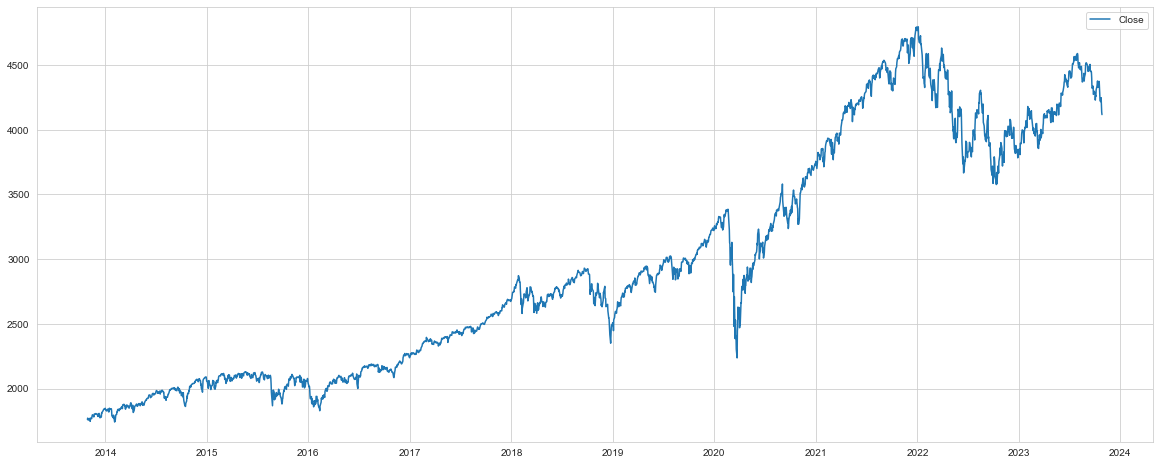

In [4]:
plt.figure(figsize=(20,8))


plt.plot(SP_df['Date'], SP_df['Close'], label = "Close")
plt.legend()

# Classification Tasks

In [5]:
SP_cl = SP_df[['Date', 'Close','Momentum', 'IndexMomentum', 'Lag-1','Lag-2','Lag-3','Lag-4','Lag-5']].iloc[6:]

SP_cl =  SP_cl.reset_index(drop=True)

SP_cl

,Date,Close,Momentum,IndexMomentum,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5
0,2013-11-05,1762.97,0,0.6,1767.93,1761.64,1756.54,1763.31,1771.95
1,2013-11-06,1770.49,1,0.4,1762.97,1767.93,1761.64,1756.54,1763.31
2,2013-11-07,1747.15,0,0.6,1770.49,1762.97,1767.93,1761.64,1756.54
3,2013-11-08,1770.61,1,0.6,1747.15,1770.49,1762.97,1767.93,1761.64
4,2013-11-11,1771.89,1,0.6,1770.61,1747.15,1770.49,1762.97,1767.93
...,...,...,...,...,...,...,...,...,...
2507,2023-10-23,4217.04,0,0.2,4224.16,4278.00,4314.60,4373.20,4373.63
2508,2023-10-24,4247.68,1,0.0,4217.04,4224.16,4278.00,4314.60,4373.20
2509,2023-10-25,4186.77,0,0.2,4247.68,4217.04,4224.16,4278.00,4314.60
2510,2023-10-26,4137.23,0,0.2,4186.77,4247.68,4217.04,4224.16,4278.00


In [6]:
tss = TimeSeriesSplit(n_splits = 4)

# Defining X and y for classification tasks
X = SP_cl.drop(labels=['Date', 'Momentum','Close', 'IndexMomentum', 'Lag-2','Lag-3', 'Lag-4','Lag-5'], axis=1)
y = SP_cl['Momentum']

print(X.head())

# Train-Test Split
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

     Lag-1
0  1767.93
1  1762.97
2  1770.49
3  1747.15
4  1770.61


## k-NN Classification

In [7]:
def KNN(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    return pred

In [8]:
for k in range(1,10):
    print(classification_report(y_test, KNN(k)))

              precision    recall  f1-score   support

           0       0.56      0.51      0.53       264
           1       0.50      0.55      0.53       238

    accuracy                           0.53       502
   macro avg       0.53      0.53      0.53       502
weighted avg       0.53      0.53      0.53       502

              precision    recall  f1-score   support

           0       0.54      0.72      0.62       264
           1       0.50      0.32      0.39       238

    accuracy                           0.53       502
   macro avg       0.52      0.52      0.50       502
weighted avg       0.52      0.53      0.51       502

              precision    recall  f1-score   support

           0       0.55      0.39      0.46       264
           1       0.49      0.66      0.56       238

    accuracy                           0.51       502
   macro avg       0.52      0.52      0.51       502
weighted avg       0.52      0.51      0.51       502

              preci

## Support Vector Machines Classification

### Linear Kernel

In [9]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train,y_train)
y_pred_svm_linear = svm_linear.predict(X_test)
print(classification_report(y_test, y_pred_svm_linear))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       264
           1       0.47      1.00      0.64       238

    accuracy                           0.47       502
   macro avg       0.24      0.50      0.32       502
weighted avg       0.22      0.47      0.30       502



C:\Users\hites\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hites\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hites\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Polynomial Kernel

In [10]:
svm_poly = svm.SVC(kernel='poly', degree = 2)
svm_poly.fit(X_train,y_train)
y_pred_svm_poly = svm_poly.predict(X_test)
print(classification_report(y_test, y_pred_svm_poly))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       264
           1       0.47      1.00      0.64       238

    accuracy                           0.47       502
   macro avg       0.24      0.50      0.32       502
weighted avg       0.22      0.47      0.30       502



C:\Users\hites\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hites\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hites\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree Classifier

In [11]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)

y_pred_dtree = decision_tree.predict(X_test)

metrics.confusion_matrix(y_test, y_pred_dtree)

array([[134, 130],
       [106, 132]], dtype=int64)

In [12]:
print(classification_report(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       0.56      0.51      0.53       264
           1       0.50      0.55      0.53       238

    accuracy                           0.53       502
   macro avg       0.53      0.53      0.53       502
weighted avg       0.53      0.53      0.53       502



## Random Forest Classifier

In [14]:
random_forest = RandomForestClassifier(max_depth=25, random_state=8)

random_forest.fit(X_train,y_train)
y_pred_random_forest = random_forest.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred_random_forest))

print(classification_report(y_test,y_pred_random_forest))

[[133 131]
 [106 132]]
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       264
           1       0.50      0.55      0.53       238

    accuracy                           0.53       502
   macro avg       0.53      0.53      0.53       502
weighted avg       0.53      0.53      0.53       502

